In [1]:
from abc import ABC, abstractmethod
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [3]:
## This is the general implementation of RL model applied in the following article  
# Go and no-go learning in reward and punishment: Interactions between affect and effect
# However, I have generalized setups in which we can more than one or two actions. 

class State:
    def __init__(self, num_actions):
        # Initialize Q-values and bias for each action in this state
        self.Q = np.zeros(num_actions)
        self.bias = np.zeros(num_actions)  # Bias vector for each action

class MDP(ABC):
    def __init__(self, states, rho=1.0, epsilon=0.1, irreducible_noise=0.1):
        """
        Abstract MDP class with states and parameters for learning.
        
        Parameters:
        - states (list of State objects): List of states in the MDP.
        - rho (float): Reward sensitivity parameter.
        - epsilon (float): Learning rate.
        - irreducible_noise (float): Noise factor for action selection.
        """
        self.states = states
        self.rho = rho
        self.epsilon = epsilon
        self.irreducible_noise = irreducible_noise

    @abstractmethod
    def action_probability(self, state, action):
        """Calculate probability of selecting an action in a given state."""
        pass

    @abstractmethod
    def update_Q(self, state, action, reward):
        """Update Q-value for a given state-action pair."""
        pass

    def simulate(self, state_sequence, action_sequence, rewards_sequence):
        """
        Simulate the MDP with a sequence of states, actions, and rewards, updating Q-values.

        Parameters:
        - state_sequence (list of int): Indices of states in the order they are visited.
        - action_sequence (list of int): The actions taken in each corresponding state.
        - rewards_sequence (list of float): Rewards received for each action taken.

        Returns:
        - list of list of float: Action probabilities for each state in the sequence.
        """
        action_probabilities = []

        for t, (state_idx, action, reward) in enumerate(zip(state_sequence, action_sequence, rewards_sequence)):
            state = self.states[state_idx]
            
            # Get action probabilities for all actions in the current state
            probs = [self.action_probability(state, a) for a in range(len(state.Q))]
            action_probabilities.append(probs[action])
            
            # Update Q for the given action at trial t
            self.update_Q(state, action, reward)

        return action_probabilities
    


# Child class with a specific implementation for action probability and Q-value update
class SimpleMDP(MDP):
    def action_probability(self, state, action):
        """
        Specific implementation for calculating action probability with noise factor.

        Parameters:
        - state (State): Current state.
        - action (int): Index of the action for which to calculate the probability.

        Returns:
        - float: Probability of selecting the action.
        """
        weights = state.Q + state.bias
        exp_weights = np.exp(weights)
        
        # Using Equation (2): Calculate probability with irreducible noise
        prob = self.irreducible_noise * (exp_weights[action] / np.sum(exp_weights)) + (1 - self.irreducible_noise) / len(state.Q)
        return prob

    def update_Q(self, state, action, reward):
        """
        Specific implementation of Q-value update using a simple learning rule.

        Parameters:
        - state (State): The state to update.
        - action (int): The action taken in this state.
        - reward (float): The reward received.
        """
        # Equation (3): Update rule for Q-value
        state.Q[action] += self.epsilon * (self.rho * reward - state.Q[action])
    def logistic_transform(self, x):
        """
        Transform parameter from [0,1] range to (-inf, inf) using logistic transformation.
        """
        return np.log(x / (1 - x))

    def inv_logistic_transform(self, x):
        """
        Inverse logistic transform: transform parameter from (-inf, inf) back to [0,1].
        """
        return 1 / (1 + np.exp(-x))

    def update_bias_vector(self):
        """
        Update the bias vector for all states to [bias, 0] as per the two-action structure.
        """
        for state in self.states:
            state.bias_vector = np.array([self.bias, 0])
    
    def update_parameters(self, h):
        """
        Update MDP parameters using transformed parameters.
        
        Parameters:
        - h (array): Transformed parameters in Gaussian space [h_rho, h_epsilon, h_noise, h_bias].
        """
        # Inverse transformations
        self.rho = self.inv_logistic_transform(h[0])
        self.epsilon = self.inv_logistic_transform(h[1])
        self.irreducible_noise = self.inv_logistic_transform(h[2])
        self.bias = np.exp(h[3])  # bias transformed using ln(b)

        # Update all states' bias vector with new bias value
        self.update_bias_vector()



class ModelFittingEM:
    def __init__(self, mdp, num_subjects, prior_mean=None, prior_variance=None):
        """
        Initialize ModelFittingEM with vectorized prior mean and variance.
        
        Parameters:
        - mdp (MDP): Instance of the MDP class.
        - num_subjects (int): Number of subjects.
        - prior_mean (array): Prior mean for each parameter, default to zeros if None.
        - prior_variance (array): Prior variance for each parameter, default to ones if None.
        """
        self.mdp = mdp
        self.num_subjects = num_subjects
        self.prior_mean = prior_mean if prior_mean is not None else np.zeros(4)
        self.prior_variance = prior_variance if prior_variance is not None else np.ones(4)
        # Initial parameter guesses in Gaussian space for each subject
        self.subject_params = np.random.normal(self.prior_mean, np.sqrt(self.prior_variance), (num_subjects, 4))

    def log_likelihood(self, params, states, actions, rewards):
        """
        Calculate log likelihood of actions given parameters using MDP's simulate function.
        """
        self.mdp.update_parameters(params)
        simulated_probs = self.mdp.simulate(states, actions, rewards)
        log_likelihood = np.sum(np.log(simulated_probs))
        return -log_likelihood  # Negative for minimization

    def log_posterior(self, params, states, actions, rewards):
        """
        Calculate log posterior, which is log likelihood + log prior.
        """
        log_likelihood = -self.log_likelihood(params, states, actions, rewards)
        # Calculate log-prior, using vectorized mean and variance for each parameter
        log_prior = -0.5 * np.sum((params - self.prior_mean) ** 2 / self.prior_variance)
        return -(log_likelihood + log_prior)

    def E_step(self, states, actions, rewards):
        """
        E-step: Estimate subject parameters using a Laplacian approximation.
        """
        subject_means = []
        subject_variances = []
        
        for i in range(self.num_subjects):
            # Minimize the negative log-posterior for parameter estimation
            result = minimize(self.log_posterior, self.subject_params[i],
                            args=(states[i], actions[i], rewards[i]),
                            method='L-BFGS-B')

            # Get the estimated mean parameters
            mean_estimate = result.x

            # Assign default variance since L-BFGS-B does not provide Hessian; 
            # variance estimate can be refined with other methods if needed
            variance_estimate = np.ones(4) * 0.1

            # Append the mean and variance for each subject
            subject_means.append(mean_estimate)
            subject_variances.append(variance_estimate)
        
        # Convert lists to numpy arrays for a 2D structure: rows=subjects, columns=parameters
        subject_means = np.array(subject_means)
        subject_variances = np.array(subject_variances)
    
        return subject_means, subject_variances


    def M_step(self, subject_means, subject_variances):
        """
        M-step: Update the shared prior parameters.
        """
        self.prior_mean = np.mean(subject_means, axis=0)
        self.prior_variance = np.mean([m**2 + var for m, var in zip(subject_means, subject_variances)], axis=0) - self.prior_mean**2

    def fit(self, states, actions, rewards, num_iterations=10):
        """
        Fit the model parameters using the EM algorithm.
        """
        for iteration in range(num_iterations):
            subject_means, subject_variances = self.E_step(states, actions, rewards)
            self.M_step(subject_means, subject_variances)
        
        return {
            'prior_mean': self.prior_mean,
            'prior_variance': self.prior_variance,
            'subject_means': subject_means,
            'subject_variances': subject_variances
        }

## Test the model

In [42]:
# Define states with 3 actions each and assign biases
states = [State(num_actions=3) for _ in range(5)]


for state in states:
    state.bias = np.array([0.2, -0.1, 0.3])  # Example bias values for each action

# Instantiate SimpleMDP
mdp_instance = SimpleMDP(states=states, rho=0.5, epsilon=0.1, irreducible_noise=0.1)

# Define sequences for simulation
state_sequence = [0, 1, 2, 3, 4]      # State sequence
action_sequence = [0, 2, 1, 0, 2]     # Predefined actions for each state
rewards_sequence = [1, 0, 1, -1, 1]   # Rewards received for each action

# Run simulation and print action probabilities
action_probs = mdp_instance.simulate(state_sequence, action_sequence, rewards_sequence)
for i, probs in enumerate(action_probs):
    print(f"State {state_sequence[i]} action probabilities: {probs}")


State 0 action probabilities: 0.3351371685289223
State 1 action probabilities: 0.3388325768016878
State 2 action probabilities: 0.32603025466938984
State 3 action probabilities: 0.3351371685289223
State 4 action probabilities: 0.3388325768016878


In [4]:
# Example Usage
# Define states with 2 actions each
states = [State(num_actions=2) for _ in range(5)]
mdp = SimpleMDP(states=states, rho=0.5, epsilon=0.1, irreducible_noise=0.1)

# Initialize actions and rewards for multiple subjects
num_subjects = 10
states = np.array([[1, 2, 0, 3, 4] for _ in range(num_subjects)])
actions = np.array([[0, 1, 0, 1, 0] for _ in range(num_subjects)])  # Example action sequences
rewards = np.array([[1, 0, 1, -1, 1] for _ in range(num_subjects)])  # Example reward sequences

# Run EM model fitting
model_fitter = ModelFittingEM(mdp, num_subjects)
estimated_params = model_fitter.fit(states, actions, rewards)

print("Estimated parameters:", estimated_params)

Estimated parameters: {'prior_mean': array([-0.14099995, -0.56549842, -0.40689421,  0.28549625]), 'prior_variance': array([1.01695324, 1.03238149, 0.93356563, 1.00189538]), 'subject_means': array([[ 0.67336005, -0.16018027,  0.02807678, -0.40255431],
       [ 0.33689106,  1.53810252, -1.87413394,  1.07896328],
       [ 1.48046864, -1.83464205, -0.56706416, -1.0092095 ],
       [-2.09075655,  0.06359859,  0.42995842, -0.51360034],
       [ 0.06829634, -1.16230712, -1.57863008, -0.12954683],
       [-0.25599617, -0.85736616, -1.10489998, -0.00908887],
       [-1.21770441, -0.56549248,  0.82300084,  2.23783763],
       [ 0.03647748, -1.87582997,  0.01803756,  1.34031944],
       [-0.76217894,  0.10704919,  0.75914165, -0.29920395],
       [ 0.32114296, -0.90791645, -1.00242923,  0.56104595]]), 'subject_variances': array([[0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1],
   

In [5]:
print(states.shape)
print(actions.shape)
print(rewards.shape)

(10, 5)
(10, 5)
(10, 5)


## Simulate Subjects Data

In [23]:
# Define reward probabilities for each context
CONTEXTS = {
    'go_to_win': {'go': (0.8, 1), 'no-go': (0.2, 1)},
    'no_go_to_win': {'go': (0.2, 1), 'no-go': (0.8, 1)},
    'go_to_avoid_loss': {'go': (0.8, 0), 'no-go': (0.2, -1)},
    'no_go_to_avoid_loss': {'go': (0.2, -1), 'no-go': (0.8, 0)}
}

class State:
    def __init__(self, num_actions=2):
        self.Q = np.zeros(num_actions)  # Initialize Q-values for each action in the state
        self.bias = np.zeros(num_actions)  # Initialize action biases

class SubjectSimulator(ABC):
    def __init__(self, h):
        # Set up the parameters for this subject's RL model based on h (parameters in Gaussian space)
        self.rho = self.inv_logistic_transform(h[0])
        self.epsilon = self.inv_logistic_transform(h[1])
        self.noise = self.inv_logistic_transform(h[2])  # ξ (irreducible noise)
        self.bias = np.exp(h[3])  # bias transformed with exp for [b, 0] format

    @staticmethod
    def inv_logistic_transform(x):
        return 1 / (1 + np.exp(-x))
    
    @abstractmethod
    def choose_action(self, state):
        """
        Abstract method for choosing an action based on the RL model and current state.
        """
        pass
    
    @abstractmethod
    def get_reward(self, state, action):
        """
        Abstract method for determining the reward based on context and action.
        """
        pass
    
    @abstractmethod
    def update_Q(self, state, action, reward):
        """
        Abstract method for updating the Q-values based on the reward received.
        """
        pass

class SimpleSubjectSimulator(SubjectSimulator):
    def choose_action(self, state):
        # Calculate weights W(a|s) for each action based on Q-values and biases
        weights = state.Q + state.bias
        exp_weights = np.exp(weights)
        
        # Calculate the softmax probability with irreducible noise ξ
        probabilities = (self.noise * (exp_weights / np.sum(exp_weights))) + (1 - self.noise)/2
        
        # Choose the action based on the calculated probabilities
        action_index = np.random.choice([0, 1], p=probabilities)
        return 'go' if action_index == 0 else 'no-go'
    
    def get_reward(self, state, action):
        # Determine the reward based on context and action using np.random.rand for probabilistic selection
        prob, reward_value = CONTEXTS[state][action]
        return reward_value if np.random.rand() < prob else 0
    
    def update_Q(self, state, action, reward):
        """
        Specific implementation of Q-value update using a simple learning rule.
        
        Parameters:
        - state (State): The state to update.
        - action (int): The action taken in this state.
        - reward (float): The reward received.
        """
        state.Q[action] += self.epsilon * (self.rho * reward - state.Q[action])

def generate_subject_params(num_subjects=25, mean=1, variance=1):
    # Generate parameters h (Gaussian space) for each subject, fixed mean and variance
    return np.random.normal(mean, np.sqrt(variance), (num_subjects, 4))

# def simulate_subjects(num_subjects=25, num_trials=36):
#     # Define contexts for each state
#     contexts = ['go_to_win', 'no_go_to_win', 'go_to_avoid_loss', 'no_go_to_avoid_loss']
    
#     # Generate subject parameters in Gaussian space
#     subject_params = generate_subject_params(num_subjects)
    
#     # Initialize storage for each subject's simulation results
#     all_subject_data = []

#     for h in subject_params:
#         # Initialize the subject's simulator with their individual parameters
#         simulator = SimpleSubjectSimulator(h)
        
#         # Generate a random sequence of states (contexts) for the subject
#         states_sequence = np.random.choice(contexts, num_trials)
        
#         # Initialize states with Q values and biases
#         state_objects = {context: State() for context in contexts}
        
#         subject_data = {
#             'states': [],
#             'actions': [],
#             'rewards': []
#         }
        
#         for state_name in states_sequence:
#             state = state_objects[state_name]
            
#             # Simulate action selection and reward based on the context
#             action = simulator.choose_action(state)
#             reward = simulator.get_reward(state_name, action)
            
#             # Update Q-values based on reward
#             action_index = 0 if action == 'go' else 1
#             simulator.update_Q(state, action_index, reward)
            
#             # Store the data for each trial
#             subject_data['states'].append(state_name)
#             subject_data['actions'].append(action)
#             subject_data['rewards'].append(reward)
        
#         # Append the subject's data to the main list
#         all_subject_data.append(subject_data)
    
#     return all_subject_data, subject_params

def simulate_subjects(num_subjects=25, num_trials=36):
    # Define contexts for each state
    contexts = ['go_to_win', 'no_go_to_win', 'go_to_avoid_loss', 'no_go_to_avoid_loss']
    
    # Generate subject parameters in Gaussian space
    subject_params = generate_subject_params(num_subjects)
    
    # Initialize 2D arrays to store states, actions, and rewards
    states_array = np.empty((num_subjects, num_trials), dtype=object)
    actions_array = np.empty((num_subjects, num_trials), dtype=object)
    rewards_array = np.zeros((num_subjects, num_trials))

    for subj_idx, h in enumerate(subject_params):
        # Initialize the subject's simulator with their individual parameters
        simulator = SimpleSubjectSimulator(h)
        
        # Generate a random sequence of states (contexts) for the subject
        states_sequence = np.random.choice([0], num_trials)
        
        # Initialize states with Q values and biases
        state_objects = {context: State() for context in contexts}
        
        for trial_idx, state_idex in enumerate(states_sequence):
            state_name = contexts[state_idex]
            state = state_objects[state_name]
            
            # Simulate action selection and reward based on the context
            action = simulator.choose_action(state)
            reward = simulator.get_reward(state_name, action)
            
            # Update Q-values based on reward
            action_index = 0 if action == 'go' else 1
            simulator.update_Q(state, action_index, reward)
            
            # Store the data in the arrays
            states_array[subj_idx, trial_idx] = state_idex
            actions_array[subj_idx, trial_idx] = action_index
            rewards_array[subj_idx, trial_idx] = reward
    
    return states_array, actions_array, rewards_array, subject_params


# Run the simulation for 25 subjects and 36 trials per subject
states_array, actions_array, rewards_array, subject_params = simulate_subjects(25,60)

# # Example output for the first subject
# print("Example data for the first subject:")
# print("States:", subject_behavior_data[0]['states'])
# print("Actions:", subject_behavior_data[0]['actions'])
# print("Rewards:", subject_behavior_data[0]['rewards'])
# print(subject_parameters[0])


print("States:", states_array.shape)
print("Actions:", actions_array.shape)
print("Rewards:", rewards_array.shape)

States: (25, 60)
Actions: (25, 60)
Rewards: (25, 60)


In [17]:
subject_params.shape

(75, 4)

In [29]:
actions_array

array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0],
       [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1],
       [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],


### Fit model to data

In [24]:
states = [State(num_actions=2) for _ in range(4)]
mdp = SimpleMDP(states=states, rho=0.5, epsilon=0.1, irreducible_noise=0.1)
num_subjects = 25
# Run EM model fitting
model_fitter = ModelFittingEM(mdp, num_subjects)
estimated_params = model_fitter.fit(states_array, actions_array, rewards_array,20)

In [36]:
states_array.shape

(25, 36)

In [25]:
estimated_params["subject_means"].shape

(25, 4)

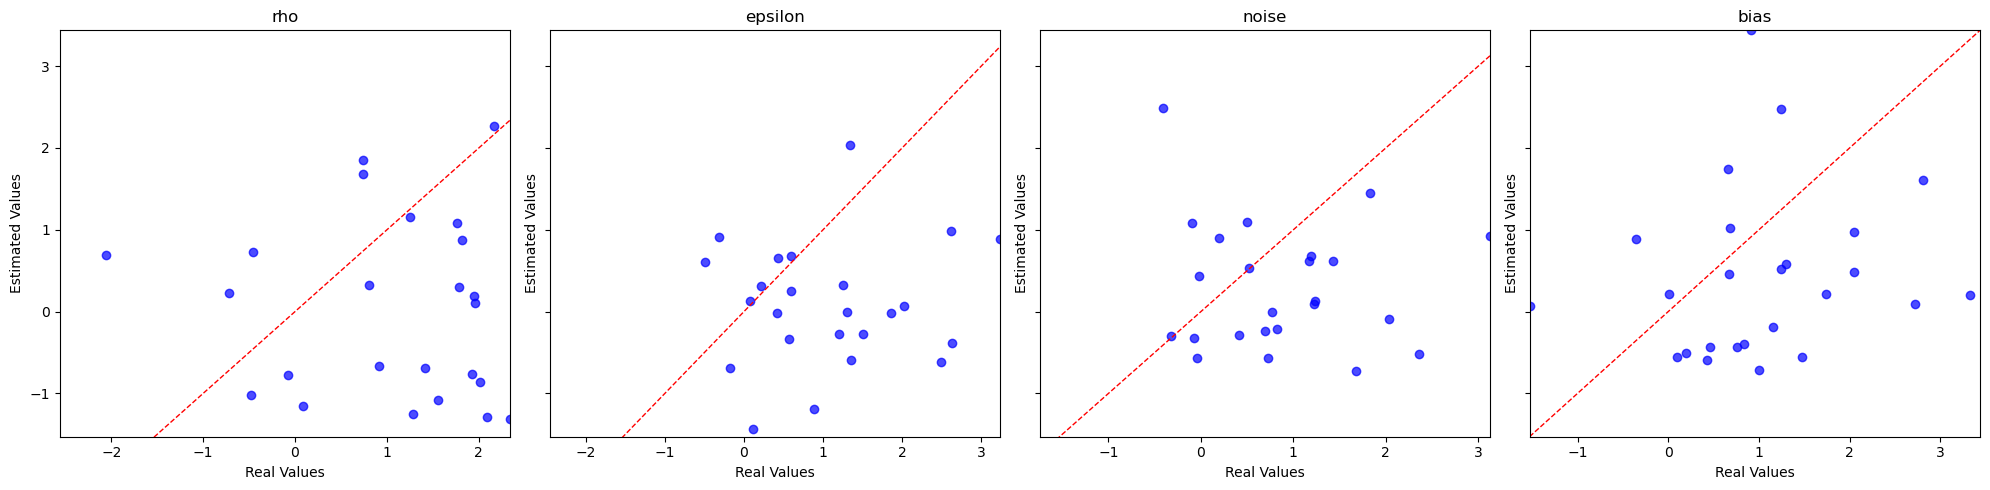

In [26]:


# Assuming real_params and estimated_params are both (num_subjects, num_parameters) arrays
# Here, each column represents a different parameter, and each row represents a subject.
# For example, let's assume real_params and estimated_params are given as:
# real_params = np.random.rand(25, 4)  # Replace with actual real parameters
# estimated_params = real_params + np.random.normal(0, 0.05, (25, 4))  # Replace with actual estimates

def plot_real_vs_estimated(real_params, estimated_params, parameter_names=None):
    num_parameters = real_params.shape[1]
    fig, axes = plt.subplots(1, num_parameters, figsize=(5 * num_parameters, 5), sharey=True)

    if parameter_names is None:
        parameter_names = [f"Parameter {i+1}" for i in range(num_parameters)]

    for i in range(num_parameters):
        ax = axes[i] if num_parameters > 1 else axes  # Adjust if only one subplot

        # Scatter plot for each parameter
        ax.scatter(real_params[:, i], estimated_params[:, i], color='blue', alpha=0.7)
        
        # Plot y=x line for reference
        min_val = min(np.min(real_params[:, i]), np.min(estimated_params[:, i]))
        max_val = max(np.max(real_params[:, i]), np.max(estimated_params[:, i]))
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1)

        # Label axes and add title for each subplot
        ax.set_xlabel("Real Values")
        ax.set_ylabel("Estimated Values")
        ax.set_title(parameter_names[i])
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

    plt.tight_layout()
    plt.show()

# Example usage (replace with actual arrays)
plot_real_vs_estimated(subject_params, estimated_params["subject_means"], parameter_names=["rho", "epsilon", "noise", "bias"])
